这是我对于Unet和attention_YNet的尝试，试着把Ynet用到的处理方式应用到Unet上。

这是第一部分,包含了:
基础导入和工具函数
图像处理类(填充/还原)
数据集类
数据加载器创建函数

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet
from functions.data import SegmentationDataset



In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("使用 GPU")
else:
    device = torch.device("cpu")
    print("使用 CPU")

使用 GPU


In [4]:
train_data, test_data = prepare_dataset("Kasthuri++") # Lucchi++ /  Kasthuri++ / VNC
PATCH_SIZE = 128 #这个暂时不需要理会，和下面的内容没关系
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

In [5]:
# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=256,                # 可选：patch大小，默认128
    stride=64,                     # 可选：滑动步长，默认64
    transform=None, # 可选： 数据增强转换，默认None
    # preProcessing= None
)

# test_dataset= SegmentationDataset(
#     data_list=train_data,          # 必需：数据列表
#     patch_size=128,                # 可选：patch大小，默认128
#     stride=64,                     # 可选：滑动步长，默认64
#     transform=None                 # 可选：数据增强转换，默认None
# )


In [6]:
# 打印数据集基本信息
train_dataset.print_dataset_info()


数据集信息:
总样本数: 44625
图像块大小: 256x256
滑动步长: 64
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 256, 256])
掩码块形状: torch.Size([1, 256, 256])



显示图片的patches: mask1043.png
原图路径: dataset\Kasthuri++\Train_In\mask1043.png
对应的Mask路径: dataset\Kasthuri++\Train_Out\mask1043.png
图片索引: 12


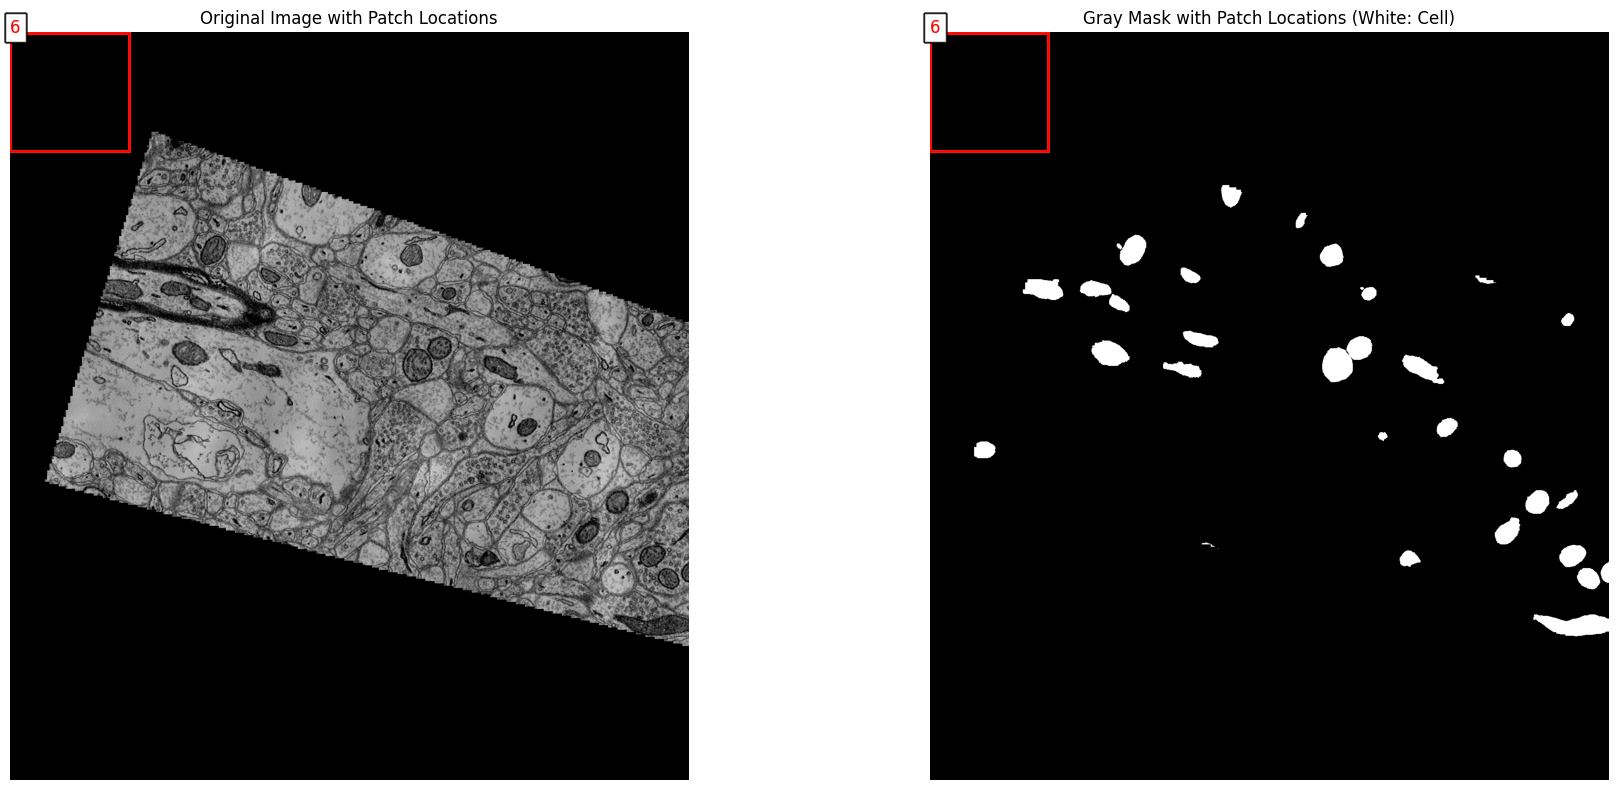

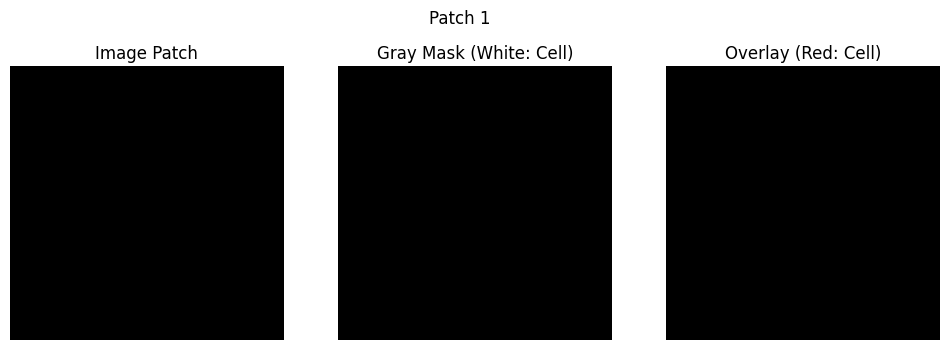

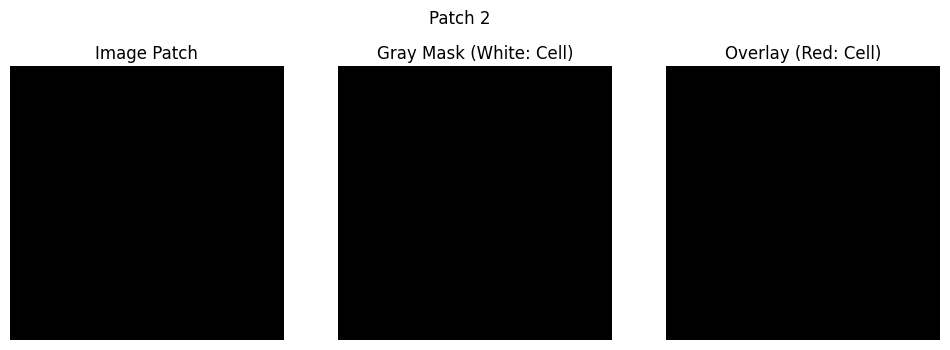

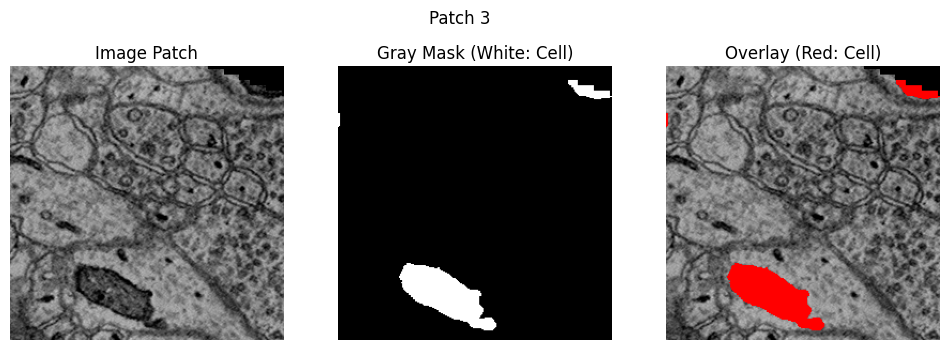

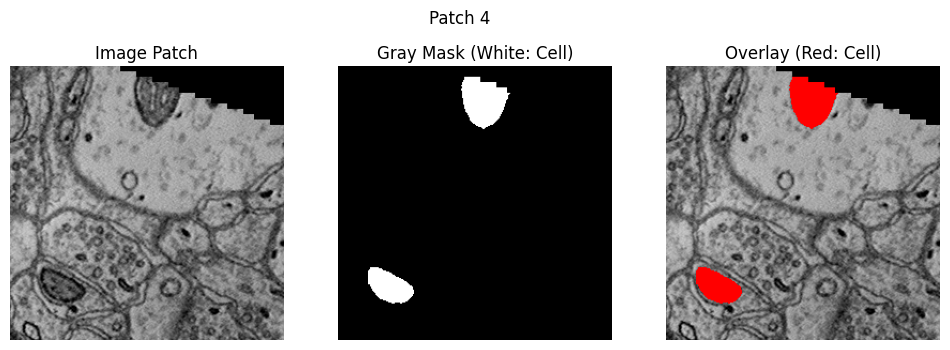

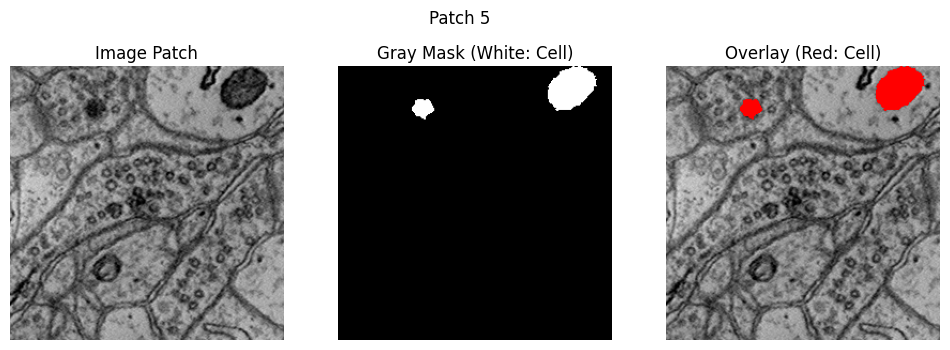

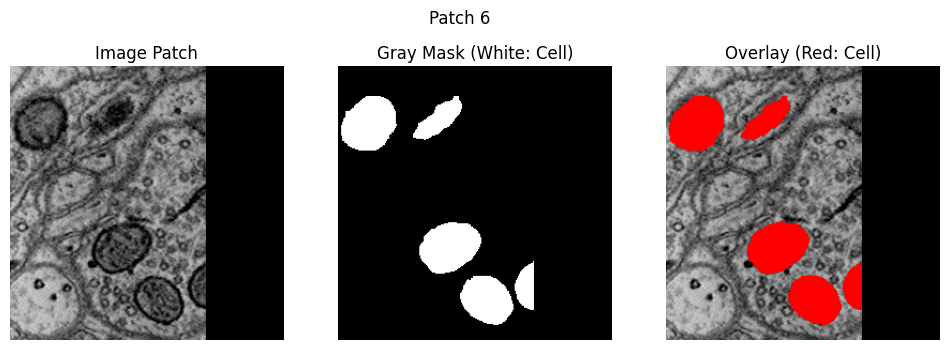

In [8]:
# 随机查看几张图片的patches
train_dataset.visualize_random_images(num_images=1, patches_per_image=6)


In [ ]:

# 使用例子 model = UNet(num_classes=1).to(device)，下面是原注释

# class SegmentationModel(nn.Module):
#     def __init__(self, num_classes):
#         super(SegmentationModel, self).__init__()
        
#         # Encoder (downsampling)
#         self.encoder = nn.Sequential(
#             self.conv_block(3, 32, stride=2),
#             self.conv_block(32, 64, stride=2),
#             self.conv_block(64, 128, stride=2),
#             self.conv_block(128, 256, stride=2)
#         )
        
#         # Decoder (upsampling)
#         self.decoder = nn.Sequential(
#             self.upconv_block(256, 128),
#             self.upconv_block(128, 64),
#             self.upconv_block(64, 32),
#             self.upconv_block(32, 32)
#         )
        
#         # Final classification layer
#         self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
#     def conv_block(self, in_channels, out_channels, stride=1):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def upconv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         # Encoder
#         features = []
#         for encoder_layer in self.encoder:
#             x = encoder_layer(x)
#             features.append(x)
        
#         # Decoder
#         for i, decoder_layer in enumerate(self.decoder):
#             x = decoder_layer(x)
#             if i < len(self.decoder) - 1:
#                 x = x + features[-i-2]  # Skip connection
        
#         # Final classification
#         x = self.final(x)
#         return x

# Custom Dataset class

# class SegmentationDataset(torch.utils.data.Dataset):
#     def __init__(self, data_list, patch_size=128, stride=64, transform=None):
#         self.data_list = data_list
#         self.patch_size = patch_size
#         self.stride = stride
#         self.transform = transform
        
#         # 预处理所有图像的patches
#         self.all_patches = []
#         self.all_masks = []
#         self.all_positions = []
#         self.all_sizes = []
#         self.all_paths = []
        
#         for item in data_list:
#             image = cv2.imread(item["image"])
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             mask = cv2.imread(item["annotation"], cv2.IMREAD_GRAYSCALE)
            
#             patches, mask_patches, positions, original_size = self.process_image_to_patches(image, mask)
            
#             for patch, mask_patch in zip(patches, mask_patches):
#                 if self.transform:
#                     patch = self.transform(patch)
                
#                 patch = torch.FloatTensor(patch.transpose(2, 0, 1)) / 255.0
#                 mask_patch = torch.FloatTensor(mask_patch).unsqueeze(0) / 255.0
                
#                 self.all_patches.append(patch)
#                 self.all_masks.append(mask_patch)
#                 self.all_positions.append(positions)
#                 self.all_sizes.append(original_size)
#                 self.all_paths.append(item["image"])

#     def process_image_to_patches(self, image, mask):
#         """处理图像和掩码为patches"""
#         h, w = image.shape[:2]
#         patches = []
#         mask_patches = []
#         positions = []
        
#         for y in range(0, h-self.patch_size+1, self.stride):
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         # 处理边缘情况
#         if h % self.stride != 0:
#             y = h - self.patch_size
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if w % self.stride != 0:
#             x = w - self.patch_size
#             for y in range(0, h-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if h % self.stride != 0 and w % self.stride != 0:
#             y = h - self.patch_size
#             x = w - self.patch_size
#             patch = image[y:y+self.patch_size, x:x+self.patch_size]
#             mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#             patches.append(patch)
#             mask_patches.append(mask_patch)
#             positions.append((y, x))
        
#         return patches, mask_patches, positions, (h, w)

#     def __len__(self):
#         return len(self.all_patches)

#     def __getitem__(self, idx):
#         return {
#             'patches': self.all_patches[idx],
#             'mask_patches': self.all_masks[idx],
#             'positions': self.all_positions[idx],
#             'original_size': self.all_sizes[idx],
#             'image_path': self.all_paths[idx]
#         } 
    
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary
    pred_mask = (pred_mask > threshold).float()

    # Calculate intersection and union
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    return iou.item(), dice.item()

# Add reconstruction function
def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
    """从patches重建完整图像"""
    h, w = original_size
    reconstructed = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    
    for patch, (y, x) in zip(patches, positions):
        patch_h = min(patch_size, h - y)
        patch_w = min(patch_size, w - x)
        reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
        count[y:y+patch_h, x:x+patch_w] += 1
    
    # 处理重叠区域
    count[count == 0] = 1
    reconstructed /= count
    return reconstructed


# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, device="cuda"):
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        
        for batch in tqdm(train_loader):
            patches = batch['patches'].to(device)
            mask_patches = batch['mask_patches'].to(device)
            
            optimizer.zero_grad()
            outputs = model(patches)
            loss = criterion(outputs, mask_patches)
            
            loss.backward()
            optimizer.step()
            
            pred_masks = torch.sigmoid(outputs) > 0.5
            iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
            
            train_loss += loss.item()
            train_iou += iou
            train_dice += dice
        
        # 计算平均值
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device)
                mask_patches = batch['mask_patches'].to(device)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = torch.sigmoid(outputs) > 0.5
                iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_dice /= len(val_loader)
        
        # 更新学习率
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model_iou.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_loss.pth')
# Inference function
def predict(model, image_path, device="cuda"):
    model.eval()
    
    # 加载图像，保持原始尺寸
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 获取原始图像尺寸
    h, w = image.shape[:2]
    
    # Patch参数
    patch_size = PATCH_SIZE
    overlap = patch_size // 2  # 50% 重叠
    
    # 计算步数
    h_steps = int(np.ceil((h - patch_size) / (patch_size - overlap))) + 1
    w_steps = int(np.ceil((w - patch_size) / (patch_size - overlap))) + 1
    
    patches_list = []
    patch_positions = []
    
    # 提取重叠的patches
    for i in range(h_steps):
        for j in range(w_steps):
            # 计算patch坐标
            y_start = min(i * (patch_size - overlap), h - patch_size)
            x_start = min(j * (patch_size - overlap), w - patch_size)
            
            # 提取patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # 标准化和通道顺序转换
            patch = patch / 255.0
            patch = patch.transpose(2, 0, 1)
            patches_list.append(patch)
            patch_positions.append((y_start, x_start))
    
    # 转换为tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # 运行推理
    with torch.no_grad():
        outputs = model(patches_tensor)
        pred_masks = torch.sigmoid(outputs) > 0.5
    
    # 初始化权重和预测图
    weight_map = np.zeros((h, w))
    pred_map = np.zeros((h, w))
    
    # 创建权重核用于混合
    y, x = np.mgrid[0:patch_size, 0:patch_size]
    weight_kernel = np.exp(-((x - patch_size/2)**2 + (y - patch_size/2)**2) / (2*(patch_size/4)**2))
    
    # 使用加权平均重建完整掩码
    for idx, (y_start, x_start) in enumerate(patch_positions):
        mask_patch = pred_masks[idx, 0].cpu().numpy()
        
        # 应用权重核
        weighted_patch = mask_patch * weight_kernel
        
        # 添加到预测和权重图
        y_end = min(y_start + patch_size, h)
        x_end = min(x_start + patch_size, w)
        patch_h = y_end - y_start
        patch_w = x_end - x_start
        
        pred_map[y_start:y_end, x_start:x_end] += weighted_patch[:patch_h, :patch_w]
        weight_map[y_start:y_end, x_start:x_end] += weight_kernel[:patch_h, :patch_w]
    
    # 权重归一化
    full_mask = np.divide(pred_map, weight_map, where=weight_map > 0)
    full_mask = (full_mask > 0.5).astype(np.float32)
    
    return full_mask


In [ ]:
# Create datasets
# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_data)
test_dataset = SegmentationDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(num_classes=1).to(device)

# Train model
train_model(model, train_loader, test_loader, num_epochs=50, device=device)







上面的测试： train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
patch_size=128, stride=64   


100%|██████████| 1702/1702 [21:33<00:00,  1.32it/s]
Epoch 1/50:
Train Loss: 0.0931, IoU: 0.7630, Dice: 0.8512
Val Loss: 0.0560, IoU: 0.7202, Dice: 0.8242
100%|██████████| 1702/1702 [30:43<00:00,  1.08s/it]
Epoch 2/50:
Train Loss: 0.0175, IoU: 0.9148, Dice: 0.9547
Val Loss: 0.0529, IoU: 0.7448, Dice: 0.8404
100%|██████████| 1702/1702 [30:27<00:00,  1.07s/it]
Epoch 3/50:
Train Loss: 0.0120, IoU: 0.9370, Dice: 0.9672
Val Loss: 0.0635, IoU: 0.7372, Dice: 0.8368

训练：
原始图像/掩码 -> 切分为128x128 patches(stride=64) -> 数据标准化(/255.0) -> 通道转换(HWC->CHW) -> 训练数据集构建
                                                                                                    ↓
                                                                                              模型训练循环
                                                                                                    ↓
                                                                                        保存最佳模型(IoU/Loss)

预测：
输入图像 -> 保持原始尺寸 -> 切分重叠patches(overlap=64) -> 数据标准化和通道转换 -> 模型预测
                                                                                    ↓
                                                            输出完整掩码 <- 加权重建 <- patch级预测结果


可使用counterbalance做对抗，train的部分需要在与处理下保证不同类的数据集特征倾向一致（这个之前没有做好导致泛化效率低）

首要目标：train和test的patch分割，都要使用patch进行，保证重叠度
         train部分的预处理操作不够完善（旋转和缩放没有设置，可能导致斜放图片以及比例不同的图片准确度下降），导致AB类数据集特征倾向不一致，泛化能力差
         后处理部分，目前只进行了形态学的消去小噪点，后续可以进行优化(打点，填充，闭运算等) 
         模块提取 后处理和预处理的内容
         还要加一个打点，这个可以去turnfinesam2那边找，记得把sam的内容也丢进来
        下面的是get point的方法，在 turnfinesam2_fix那边，要注意看！！！！把取点的后处理也拖动到unet中
         def get_points(mask, num_points):  # Sample points inside the input mask
            points = []
            coords = np.argwhere(mask > 0)
            for i in range(num_points):
                yx = np.array(coords[np.random.randint(len(coords))])
                points.append([[yx[1], yx[0]]])
            return np.array(points)
        这个函数可以随机选取mask中点，然后返回，这样偏差会小一些，记住！打点操作是后处理

准备尝试轻量化的数据测试，从1702降下来，看看整体效果，并且虽然加入了patch分割训练，但是还需要添加数据的预处理，比如颜色对比度的normalization，以及数据增强，还有对载入图片旋转训练（可以考虑加入其他数据进行验证，即Lucchi++和Kasthrui++混合训练），图像的后处理部分暂时可以先维持形态学的消去小噪点，后续再进行优化。

核心问题：model基础效果太差导致跨数据测试完全没效果，最大因素或许不在于size，而是颜色以及图片的细胞大小(即图片所占比例)，则测试准确度骤降，这点可以通过VNC和lucchi++数据集进行验证得到的，Lucchi model对VNC的测试甚至不如Kasthrui，但是看图片会发现虽然三类的数据集size都不一样，VNC颜色对比与K接近，而Lucchi偏向于浅色，这点也会影响模型的效果。


In [ ]:
# https://huggingface.co/CompVis/ldm-super-resolution-4x-openimages1
# Example inference
test_image_path = test_data[0]["image"]
pred_mask = predict(model, test_image_path)

# Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.imread(test_image_path))
plt.title('Original Image')
plt.subplot(132)
plt.imshow(cv2.imread(test_data[0]["annotation"], cv2.IMREAD_GRAYSCALE))
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred_mask)
plt.title('Prediction')
plt.show()

# Save model
torch.save(model.state_dict(), "overlaping_unet_segmentation_try.pth")



In [ ]:

# load from oxford_segmentation_models.pth
import torch

def load_model(model_path, num_classes, device):
    # Create an instance of your model
    model = SegmentationModel(num_classes)
    
    # Load the state dict
    state_dict = torch.load(model_path, map_location=device)
     
    # Load the state dict into your model
    model.load_state_dict(state_dict)
    
    # Move the model to the specified device
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "simple_unet_segmentation.pth"

model = load_model(model_path, num_classes, device)